## Gaussian Correlation

The goal of the project is to check the sensitivity of a Basket Default Swap (BDS) to maturity and correlation. 

Consider a 3rd-to-default BDS on a basket of 5 reference entities whose default intensities are equal to 0.15. They also share the same notional, 1M, and recovery rate, 40%. The correlation structure is as follows:
* $\rho_{12} = 0.3$
* $\rho_{45} = 0.7$
* $\rho_{13} = 0.4$
* $\rho = 0.25$ between all the others

The input parameters are:

* the market quotes of a set of Overnight Index Swaps;
* the description of the contract.

You are required to find:
1. assuming a Gaussian correlation between the assets determine the BDS spread for maturities ranging between 1 and 10 years.
2. if you then assume that the correlation is the same between each reference entity: draw a plot showing how the spread varies as a function of the correlation for various values of $\rho = [0.01, 0.1, 0.25, 0.50, 0.75, 0.99]$) and for maturities ranging between 1 and 10 years.

Comment the result.

### Notes and hints

Numerical results must be presented to the examining committee during a presentation in which the candidates will also explain the theoretical framework for multi-curve evaluation.

Remember to reuse the code we developed during the lessons in `finmarkets.py` as much as possible, instead of trying to rewrite everything from scratch!

When not possible develop your own classes.

In [ ]:
import sys
from google.colab import drive

drive.mount('/content/drive', force_remount=True)
sys.path.append('/content/drive/MyDrive/finance_course/Projects')

Mounted at /content/drive


In [ ]:
import pandas as pd
from datetime import date

pricing_date = date.today()

N = 5
n_def = 3
rho_12 = 0.3
rho_45 = 0.7
rho_13 = 0.4
rho = 0.25
nominal = 1e6
R = 0.4
l = 0.01 # lambda

ois_quotes = pd.read_excel("https://github.com/matteosan1/finance_course/raw/develop/Projects/ois_quotes.xlsx")

First of all we need to determine the discount curve from the OIS market quotes using the bootstrap technique.

* generate set of OIS according to the market quotes
* create an objective function with a discount curve and the squared sum of NPVs
* check minimization results
* create the found `DiscountCurve`

In [ ]:
from finmarkets import OvernightIndexSwap
import numpy as np

pillar_dates = [pricing_date]

oisq = np.array([[1,-0.4846],[2,-0.4842],[3,-0.4845],[4,-0.484],[5,-0.4835],
                 [6,-0.4823],[7,-0.4809],[8,-0.4792],[9,-0.476995],[10,-0.4742],
                 [11,-0.4712],[12,-0.4575],[18,-0.4442],[30,-0.351],[36,-0.334005],
                 [48,-0.2616],[60,-0.194],[72,-0.1263],[84,-0.0606],[96,0.0033],
                 [108,0.0663],[120,0.125],[132,0.17825],[144,0.2284],[180,0.352],
                 [240,0.4485],[300,0.4604],[360,0.43225],[420,0.40285],
                 [480,0.37415],[600,0.3221]])

swaps = []
for q in range(len(oisq)):
  swap = OvernightIndexSwap(1, pricing_date, 
                            0.01*oisq[q, 1], 
                            int(oisq[q,0]))
#                            ois_quotes.loc[q, 'quotes']*0.01,
#                            ois_quotes.loc[q, 'months'])
  swaps.append(swap)
  pillar_dates.append(swap.payment_dates[-1])

In [ ]:
from finmarkets import DiscountCurve
import numpy as np

def objective_function(x):
    x = np.insert(x, 0, 1)
    curve = DiscountCurve(pillar_dates, x)
    
    sum_sq = 0.0
    for swap in swaps:
        sum_sq += swap.npv(curve) ** 2
        
    return sum_sq

In [ ]:
from scipy.optimize import minimize

x0 = [1 for i in range(len(swaps))]
bounds = [(0.01, 10.0) for i in range(len(x0))]

result = minimize(objective_function, x0, bounds=bounds)

In [ ]:
print (result)
print (objective_function(x0))
print (objective_function(result.x))

      fun: 2.7446338871517912e-11
 hess_inv: <31x31 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 4.01211229e-08,  8.24039210e-08,  1.20886286e-07,  1.57330948e-07,
        1.89040925e-07,  2.17426883e-07,  2.41045764e-07,  2.58927498e-07,
        2.71916230e-07,  2.78937812e-07,  2.80416260e-07, -5.20094471e-06,
       -2.46135663e-06, -2.49217128e-06, -2.94654267e-06, -2.08513136e-06,
       -1.24180456e-06, -4.16367703e-07,  3.22655053e-07,  9.37392675e-07,
        1.39427581e-06,  1.64064702e-06,  1.65866893e-06,  2.79294197e-06,
        4.12218824e-06,  2.59447046e-06, -5.72541315e-08, -1.71188695e-06,
       -3.03517815e-06, -1.30000658e-06,  5.96910557e-07])
  message: 'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
     nfev: 160
      nit: 3
     njev: 5
   status: 0
  success: True
        x: array([1.00037707, 1.00079422, 1.00119928, 1.00161601, 1.00201874,
       1.0024309 , 1.00284013, 1.00323182, 1.00363048, 1.00400731,
       1.00439102, 1.0046575 , 1.006

In [ ]:
dfs = np.insert(result.x, 0, 1)
dc = DiscountCurve(pillar_dates, dfs)

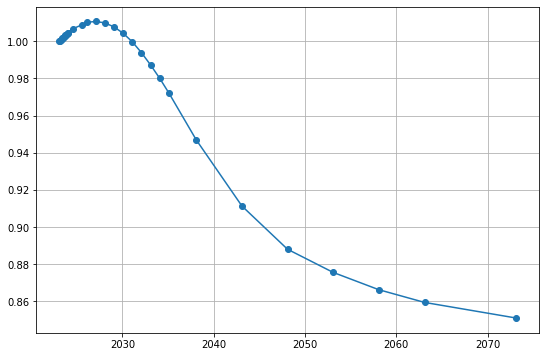

In [ ]:
from matplotlib import pyplot as plt

plt.rcParams['figure.figsize'] = (9, 6)
plt.plot(pillar_dates, dfs, marker='o')
plt.grid(True)
plt.show()

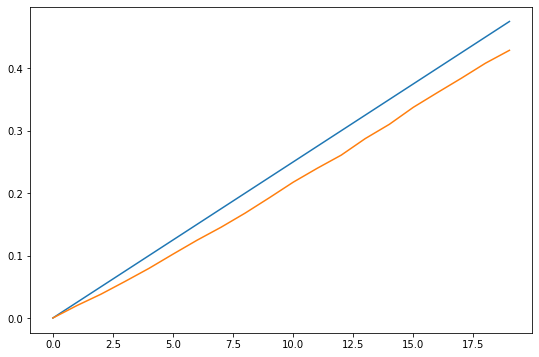

In [ ]:
from scipy.stats import multivariate_normal, norm
import numpy as np
from dateutil.relativedelta import relativedelta

np.random.seed(1)
# cov = np.array([[1,      rho_12, rho_13, rho,    rho],
#                 [rho_12, 1,      rho,    rho,    rho],
#                 [rho_13, rho,    1,      rho,    rho],
#                 [rho,    rho,    rho,    1,      rho_45],
#                 [rho,    rho,    rho,    rho_45, 1]])

N=10
rho = 0.99
cov = np.array([[1, rho, rho, rho],
                [rho, 1, rho, rho],
                [rho, rho, 1, rho],
                [rho, rho, rho, 1]])

l = 0.05
pillars = [pricing_date + relativedelta(months=6*i) for i in range(20)]
S = [np.exp(-l*0.5*i) for i in range(20)]
#S = [(1-0.025*i) for i in range(20)]

def correlated_probability(S, cov):
  N = cov.shape[1]  
  np.random.seed(1)
  mv = multivariate_normal(mean=[0]*N, cov=cov)
  x = mv.rvs(size = 10000)
  copula = norm.cdf(x)

  S_corr = []
  for s in S:
    succ = 0
    for u in copula:
      r = (u < s).sum()
      if r >= 1:#n_def:
        succ += 1
    S_corr.append(succ/len(copula))
  return S_corr

S_corr = correlated_probability(S, cov)

plt.plot(1-np.array(S))
plt.plot(1-np.array(S_corr))
plt.show()

## Alternative Method

In [ ]:
from scipy.stats import rv_continuous
from scipy.interpolate import interp1d
import numpy as np

class ExpDefault(rv_continuous):
  def __init__(self, l):
    super().__init__()
    self.ulim = 100
    self.l = l
    self.ppf_func = self.prepare_ppf()

  def _cdf(self, x):
    x[x < 0] = 0
    return (1 - np.exp(-self.l*x))

  def _pdf(self, x):
    x[x < 0] = 0
    return self.l*np.exp(-self.l*x)

  def _ppf(self, x):
    return self.ppf_func(x)

  def prepare_ppf(self):
    xs = np.linspace(0, self.ulim, 10000001)
    cdf = self.cdf(xs)/self.cdf(xs[-1])
    func_ppf = interp1d(cdf, xs, fill_value='extrapolate')
    return func_ppf

In [ ]:
from dateutil.relativedelta import relativedelta
from scipy.stats import multivariate_normal, norm

def correlated_probability_v2(pillars, cov):
  simulations = 10000
  #simulations = 5
  mean = np.zeros(N)
  mv = multivariate_normal(mean=mean, cov=cov)
  x = mv.rvs(size = simulations)
  x_unif = norm.cdf(x)
  Q = ExpDefault(l)
  default_times = Q.ppf(x_unif)

  Ts = [(p - pillars[0]).days/365 for p in pillars]
  S_corr = []
  for t in Ts:
    b = np.count_nonzero(default_times<=t, axis=1)
    #print (b)
    S_corr.append(1-len(b[b>=n_def])/simulations)
  return S_corr

In [ ]:
np.random.seed(1)
cov = np.array([[1,      rho_12, rho_13, rho,    rho],
                [rho_12, 1,      rho,    rho,    rho],
                [rho_13, rho,    1,      rho,    rho],
                [rho,    rho,    rho,    1,      rho_45],
                [rho,    rho,    rho,    rho_45, 1]])

pillars = [pricing_date + relativedelta(months=6*i) for i in range(200)]
S_corr = correlated_probability_v2(pillars, cov)
print (S_corr)

ValueError: ignored

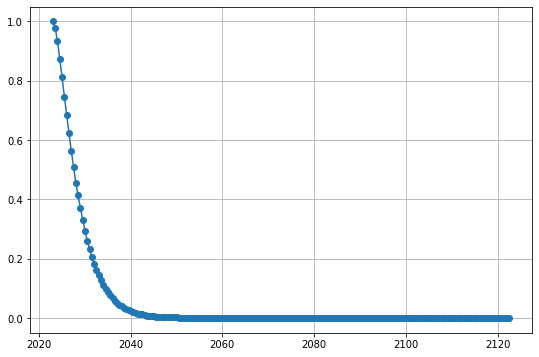

In [ ]:
from matplotlib import pyplot as plt

plt.plot(pillars, S_corr, marker='o')
plt.grid(True)
plt.show()

In [ ]:
import math
import numpy as np

class CreditCurve:
  def __init__(self, pillar_dates, pillar_ndps):
    self.pillar_dates = pillar_dates
    self.pillar_ndps = pillar_ndps
    self.pillar_days = [(pd - pillar_dates[0]).days for pd in pillar_dates]
    self.log_ndps = [math.log(ndp+1e-8) for ndp in pillar_ndps]

  def ndp(self, value_date):
    value_days = (value_date - self.pillar_dates[0]).days
    return math.exp(np.interp(value_days, self.pillar_days, self.log_ndps))

  def hazard(self, value_date):
    ndp_1 = self.ndp(value_date)
    ndp_2 = self.ndp(value_date + relativedelta(days=1))
    delta_t = 1.0 / 365.0
    h = -1.0 / ndp_1 * (ndp_2 - ndp_1) / delta_t
    return h

In [ ]:
#from finmarkets import CreditCurve

cc = CreditCurve(pillars, S_corr)
print (cc.ndp(date(2032,1,1)))

0.26138573883378013


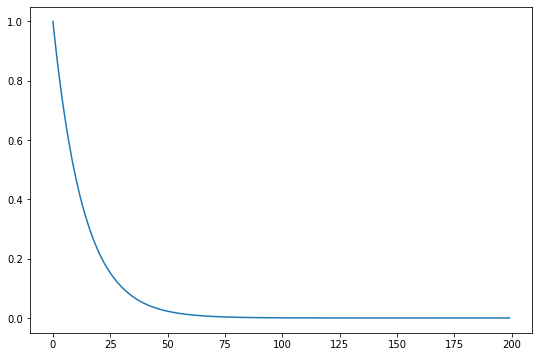

In [ ]:
plt.plot(S_corr)
plt.show()

[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
0.0
0.20159815006093756
[1.0, 1.0, 1.0, 1.0, 1.0, 0.9999, 0.9999, 0.9999, 0.9996, 0.9993, 0.9991, 0.9988, 0.9983, 0.9975, 0.9961, 0.9951, 0.9943, 0.9935, 0.9928, 0.991]
0.0005465162873772088
0.2015562597900413
[1.0, 1.0, 1.0, 1.0, 0.9998, 0.9996, 0.9993, 0.9986, 0.9978, 0.9971, 0.9961, 0.9951, 0.9937, 0.9913, 0.9887, 0.9868, 0.9842, 0.9818, 0.9788, 0.9758]
0.002366867485909711
0.20138159190806143
[1.0, 1.0, 1.0, 0.9998, 0.9995, 0.9991, 0.9988, 0.997, 0.9955, 0.9938, 0.992, 0.9886, 0.9852, 0.9827, 0.9803, 0.976, 0.9719, 0.967, 0.963, 0.9585]
0.0048594594803992456
0.20114389974436497
[1.0, 1.0, 0.9999, 0.9992, 0.9986, 0.9977, 0.9962, 0.9939, 0.9913, 0.9881, 0.9843, 0.9813, 0.9773, 0.9724, 0.9678, 0.9634, 0.9564, 0.9498, 0.9428, 0.9358]
0.009522507095091386
0.20065171996359354
[1.0, 1.0, 0.9996, 0.999, 0.9979, 0.9958, 0.9931, 0.9899, 0.9864, 0.9814, 0.9758, 0.971, 0.9644, 0.9582, 0.9519, 0

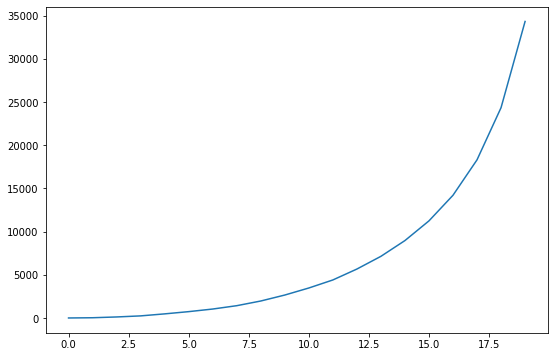

In [ ]:
from scipy.stats import multivariate_normal, norm
import numpy as np
from dateutil.relativedelta import relativedelta
from finmarkets import CreditCurve

np.random.seed(1)
rhos = [0.1*i for i in range(10)]
# cov = np.array([[1,      rho_12, rho_13, rho,    rho],
#                 [rho_12, 1,      rho,    rho,    rho],
#                 [rho_13, rho,    1,      rho,    rho],
#                 [rho,    rho,    rho,    1,      rho_45],
#                 [rho,    rho,    rho,    rho_45, 1]])
N=20
l = 0.05
pillars = [pricing_date + relativedelta(months=6*i) for i in range(20)]
S = [np.exp(-l*0.5*i) for i in range(20)]
spreads = []

def correlated_probability(S, cov, n_def):
  N = cov.shape[1]  
  np.random.seed(1)
  mv = multivariate_normal(mean=[0]*N, cov=cov)
  x = mv.rvs(size = 10000)
  copula = norm.cdf(x)

  S_corr = []
  for s in S:
    succ = 0
    for u in copula:
      r = (u < s).sum()
      if r >= n_def:
        succ += 1
    S_corr.append(succ/len(copula))
  return S_corr

rho = 0.4
for n in range(0, 20):
    cov = rho*np.ones(shape=(N, N))
    np.fill_diagonal(cov, 1)

    S_corr = correlated_probability(S, cov, n)
    print (S_corr)
    cc = CreditCurve(pillars, S_corr)
    bds = CreditDefaultSwap(1, pricing_date, 5, 0.01, 3)
    print (bds.default_leg_npv(dc, cc))
    print (bds.premium_leg_npv(dc, cc))
    spreads.append(10000*bds.default_leg_npv(dc, cc)/bds.premium_leg_npv(dc, cc))

plt.plot(spreads)
plt.show()

In [ ]:
from finmarkets import CreditDefaultSwap

s = 0.01
tenor = 3

spreads = []
for m in range(1, 11):
  bds = CreditDefaultSwap(nominal, pricing_date, m, s, tenor, R)
  spreads.append(10000*bds.default_leg_npv(dc, cc)/bds.premium_leg_npv(dc, cc)*s)

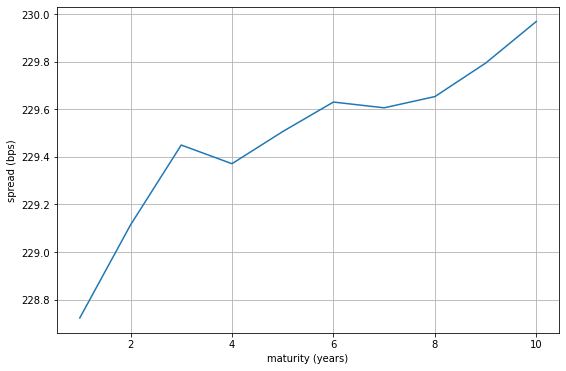

In [ ]:
plt.plot(range(1, 11), spreads)
plt.xlabel("maturity (years)")
plt.ylabel("spread (bps)")
plt.grid(True)
plt.show()

In [ ]:
S_corrs = []
spreads = []
rhos = [0.01, 0.1, 0.25, 0.5, 0.75, 0.9, 0.99]
pillars = [pricing_date + relativedelta(months=6*i) for i in range(200)]
s = 0.01

for rho in rhos:
  temp = []
  cov = rho*np.ones(shape=(N, N))
  np.fill_diagonal(cov, 1)
  
  #S_corrs.append(correlated_probability(S, cov))
  S_corrs.append(correlated_probability_v2(pillars, cov))
  cc = CreditCurve(pillars, S_corrs[-1])
  for m in range(1, 11):
    bds = CreditDefaultSwap(nominal, pricing_date, m, s, tenor, R)
    temp.append(10000*bds.default_leg_npv(dc, cc)/bds.premium_leg_npv(dc, cc)*s)
  spreads.append(temp)

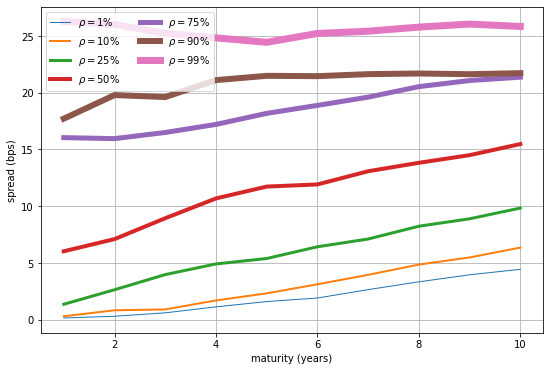

In [ ]:
from matplotlib import pyplot as plt

for i, r in enumerate(rhos):
  plt.plot(range(1, 11), spreads[i], label=r'$\rho=${:.0f}%'.format(r*100), linewidth=i+1)

plt.grid(True)
plt.legend(ncol=2)
plt.xlabel("maturity (years)")
plt.ylabel("spread (bps)")
plt.show()

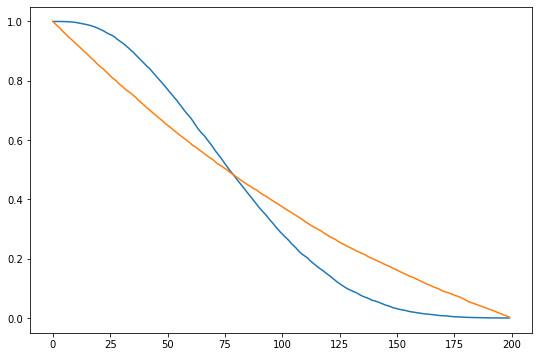

In [ ]:
rhos = [0.01, 0.99]
pillars = [pricing_date + relativedelta(months=6*i) for i in range(200)]
  
for rho in rhos:
  cov = rho*np.ones(shape=(N, N))
  np.fill_diagonal(cov, 1)
  
  #S_corrs.append(correlated_probability(S, cov))
  S_corr = correlated_probability_v2(pillars, cov)
  #print (S_corr.shape)
  #print (S_corr)

  #S_corrs.append(correlated_probability_v2(pillars, cov))
  #print (S_corrs)
  #cc = CreditCurve(pillars, S_corrs[-1])
  plt.plot(S_corr)

plt.show()